<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dense-vs-Sparse-Self-Attention" data-toc-modified-id="Dense-vs-Sparse-Self-Attention-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dense vs Sparse Self-Attention</a></span><ul class="toc-item"><li><span><a href="#Check-equality-of-sparse-implementation-with-reference" data-toc-modified-id="Check-equality-of-sparse-implementation-with-reference-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check equality of sparse implementation with reference</a></span></li></ul></li><li><span><a href="#Benchmarking-Sparse-vs-Dense-Self-Attention" data-toc-modified-id="Benchmarking-Sparse-vs-Dense-Self-Attention-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmarking Sparse vs Dense Self-Attention</a></span></li><li><span><a href="#scatter_add-vs-index_add" data-toc-modified-id="scatter_add-vs-index_add-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>scatter_add vs index_add</a></span></li><li><span><a href="#embedding-lookup-vs-index_select" data-toc-modified-id="embedding-lookup-vs-index_select-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>embedding lookup vs index_select</a></span><ul class="toc-item"><li><span><a href="#Scattered-GRU-input" data-toc-modified-id="Scattered-GRU-input-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Scattered GRU input</a></span></li></ul></li></ul></div>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys, os

# make this file executable from anywhere
#if __name__ == '__main__':

# in editor
#full_path = os.path.realpath(__file__)

# in jupyter
full_path = !pwd
full_path = full_path[0]


print(full_path)
REPO_ROOT = full_path.rsplit('ProGraML', maxsplit=1)[0] + 'ProGraML'
print(REPO_ROOT)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, REPO_ROOT)
REPO_ROOT = Path(REPO_ROOT)

/home/zacharias/ProGraML/deeplearning/ml4pl/poj104
/home/zacharias/ProGraML


In [3]:
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric import utils
from torch_geometric.utils import softmax as scatter_softmax
from torch_geometric.data import DataLoader

In [4]:
from deeplearning.ml4pl.models.ggnn.modeling import SelfAttentionMessageLayer
from deeplearning.ml4pl.models.ggnn.configs import ProGraMLBaseConfig, GraphTransformerConfig

In [5]:
from deeplearning.ml4pl.models.ggnn.modeling import (
    SelfAttentionMessageLayer, TransformerUpdateLayer, NodeEmbeddings
)

Initializing with random embeddings


In [20]:
config = GraphTransformerConfig()
ne = NodeEmbeddings(config)
x = torch.randint(8568,(10000,))
ns = ne(x)

Initializing with random embeddings


In [27]:
ns

tensor([[ 1.5007,  0.7786,  0.5091,  ..., -0.0390,  0.6470, -1.4075],
        [ 1.2099, -1.3119, -0.6140,  ..., -0.2688, -1.7967,  0.7093],
        [ 0.6308,  1.4290, -0.9300,  ...,  1.3073,  1.8656,  0.1631],
        ...,
        [-0.8768, -0.7936, -1.6952,  ..., -1.6305, -0.2348,  2.2083],
        [ 0.0888, -1.3549,  0.4236,  ...,  1.0144, -1.3774, -1.1813],
        [-0.1278, -0.7307, -1.4278,  ...,  1.2174, -1.8258, -0.5256]],
       grad_fn=<EmbeddingBackward>)

In [37]:
torch.std_mean(ns.view(-1))

(tensor(1.0013, grad_fn=<StdMeanBackward1>),
 tensor(-0.0001, grad_fn=<StdMeanBackward1>))

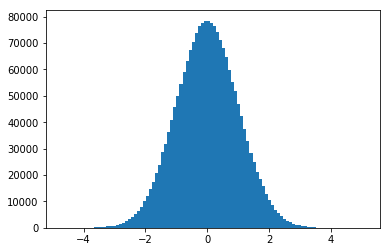

In [39]:
plt.hist(ns.view(-1).detach().numpy(), bins=100)
plt.show()


In [40]:
tu = TransformerUpdateLayer(config)

In [46]:
new = tu(ns, ns)
torch.std_mean(new)

(tensor(1.0000, grad_fn=<StdMeanBackward1>),
 tensor(-3.4937e-10, grad_fn=<StdMeanBackward1>))

In [ ]:
# att = SelfAttentionMessageLayer()

In [13]:
# real data
from deeplearning.ml4pl.poj104.dataset import POJ104Dataset
ds_dir = REPO_ROOT / 'deeplearning/ml4pl/poj104/classifyapp_data'
valid_data = POJ104Dataset(ds_dir, 'val')



In [11]:
tu()

TypeError: forward() missing 2 required positional arguments: 'messages' and 'node_states'

# Dense vs Sparse Self-Attention

In [ ]:
def print_state_dict(mod):
    for n, t in mod.state_dict().items():
        print(n, t.size())

def num_parameters(mod) -> int:
    """Compute the number of trainable parameters in a nn.Module and its children."""
    num_params = sum(param.numel() for param in mod.parameters(recurse=True) if param.requires_grad)
    return num_params, f"{num_params * 4 / 1e6:.3f}MB"

In [ ]:
config = BaseConfig.from_dict({
    'edge_type_count': 3,
    'backward_edges': True,
    'hidden_size': 200,
    'transformer_attn_bias': True,
    'transformer_num_heads': 8,
    'transformer_attn_dropout': 0.0,
})

## Check equality of sparse implementation with reference

In [ ]:
sparse_attn = SelfAttentionMessageLayer(config).to(device='cuda')

#print_state_dict(sparse_attn)
#print("")
#print(sparse_attn)
#print("")
#num_parameters(sparse_attn)

In [ ]:
# get dummy data

num_n = 5
heads = 8
hidd = 200

random_emb = nn.Parameter(torch.randn(9000, hidd, device='cuda'), requires_grad=True)

ones = torch.ones(num_n, num_n, device='cuda')

adj = torch.tril(ones, diagonal=0)
#adj = ones
print("adj matrix: edges go from (row -> column) if [row, column] == 1")
print(adj)

attn_mask = torch.tril(ones * float('-inf'), diagonal=-1)

print("")
print("attn_mask.t(): We print the transposed attention mask,")
print("bc. the reference implementation indexes the attn_mask <target, src>")
print(attn_mask.t())

edge_index = utils.dense_to_sparse(adj)[0]
print(edge_index.size())
#print(edge_index.t()[:10])

x = torch.randint(9000, (num_n,))
print(x.size())

node_states = random_emb[x]

In [ ]:
# get sparse attn on dummy data
sa_node_states, sa_weights = sparse_attn(edges=edge_index, node_states=node_states)
sa_sum = torch.sum(sa_node_states)

print(sa_sum)


in_proj = sparse_attn.qkv_in_proj.weight
in_proj_bias = sparse_attn.qkv_in_proj.bias
out_proj = sparse_attn.out_proj.weight
out_proj_bias = sparse_attn.out_proj.bias


ns = node_states.unsqueeze(1)
da_node_states, da_weights = F.multi_head_attention_forward(
                ns, ns, ns, 200, 8,
                in_proj, in_proj_bias,
                None, None, False,
                0.0, out_proj, out_proj_bias,
                training=False,
                key_padding_mask=None, need_weights=True, 
                attn_mask=attn_mask)
da_sum = torch.sum(da_node_states)


# reformat
da_node_states = da_node_states.squeeze()
da_weights = da_weights.squeeze().t()

print(da_sum)

print(da_weights)


sa_weights_matrix = torch.zeros(num_n, num_n, device='cuda')
for i, (s, t) in enumerate(edge_index.t()):
    sa_weights_matrix[s, t] = sa_weights[i]
print(sa_weights_matrix)
#print(sa_weights)

In [ ]:
# assert similarity of sums of outputs
check1 = torch.abs(sa_sum - da_sum)
print((check1 < 1e-7).item())
print(torch.max(check1).item())
# assert similarity of attention weights for complete graphs
check2 = torch.abs(da_weights - sa_weights_matrix )
print(torch.all(check2 < 1e-7).item())
print(torch.max(check2).item())

# assert similarity of self-attention output (new node states)
check3 = torch.abs(da_node_states - sa_node_states)
print(torch.all(check3 < 1e-7).item())
print(torch.max(check3).item())



# Benchmarking Sparse vs Dense Self-Attention

In [ ]:
def satt(x, emb_table, edge_index):
    node_states = emb_table[x]
    s = sparse_attn(edges=edge_index, node_states=node_states)
    loss = torch.sum(s[0])
    loss.backward()
    torch.cuda.synchronize()

def datt(x, emb_table, attn_mask):
    query = emb_table[x.unsqueeze(1)]
    s = dense_attn(query, query, query, attn_mask=attn_mask, need_weights=False)
    loss = torch.sum(s[0])
    loss.backward()
    torch.cuda.synchronize()

def benchmark_on_causal(s,n):
    for num_n in [2**i for i in range(s,n+1)]:
        print(num_n)
        with torch.no_grad():
            causal_mask = (torch.triu(torch.ones(num_n, num_n, device='cuda')) - 1) * 1e4
            edge_index = utils.dense_to_sparse(causal_mask)[0]
            print(edge_index.size())
            x = torch.randint(9000, (num_n,))
        torch.cuda.synchronize()
        #print("sparse")
        %timeit satt(x, random_emb, edge_index)
        
        #print("dense")
        try:
            %timeit datt(x, random_emb, causal_mask)
        except RuntimeError:
            print("Dense OOM")
        del causal_mask
        del edge_index
        del x


In [ ]:
benchmark_on_causal(8, 14)

In [ ]:

def benchmark_on_real(s,n):
    for bsz in [2**i for i in range(s,n+1)]:
        dl = DataLoader(valid_data, batch_size=bsz)
        print(bsz)
        for graph in dl:
            graph.to(device='cuda')
            print(graph)
            break

        with torch.no_grad():
            x = graph.x[:,0]
            edge_index = graph.edge_index

        torch.cuda.synchronize()
        %timeit satt(x, random_emb, edge_index)
        
        try:
            with torch.no_grad():
                mask = (1 - utils.to_dense_adj(graph.edge_index).squeeze() ) * -10000
                print(f"Size of adjacency matrix: {mask.size()[0]**2 * 4 / 1e6:,.2f} MB")
            torch.cuda.synchronize()    
            %timeit datt(x, random_emb, mask)
        except RuntimeError:
            print("Dense OOM")
            
        print("----"*10)

In [ ]:
benchmark_on_real(0, 10)

In [ ]:
dl = DataLoader(valid_data, batch_size=64)
for graph in dl:
    graph.to(device='cuda')
    break
print(graph)

with torch.no_grad():
    adj = (1 - to_dense_adj(graph.edge_index).squeeze() ) * -10000
adj.size(), adj.device
print(f"Size of adjacency matrix: {adj.size()[0]**2 * 4 / 1e6:,.2f} MB")

# scatter_add vs index_add

In [1]:
torch.utils.

NameError: name 'torch' is not defined

In [ ]:
target = torch.randn(2000,200, requires_grad=True, device='cuda')
mbs = torch.randn(10000, 200, device='cuda', requires_grad=True)
index = torch.randint(0, 2000, [10000], device='cuda')

In [ ]:
sa = torch.zeros_like(target)
sa.scatter_add_(0, index.unsqueeze(1).repeat(1, 200), mbs)

s = torch.zeros_like(target)
s.index_add_(0, index, mbs)

torch.max(torch.abs(sa - s)), torch.argmax(torch.abs(sa - s))

In [ ]:
def ia():
    s = torch.zeros_like(target)
    s.index_add_(0, index, mbs)
    loss = torch.sum(s)
    loss.backward()
    torch.cuda.synchronize()

def sa():
    s = torch.zeros_like(target)
    s.scatter_add_(0, index.unsqueeze(1).repeat(1, 200), mbs)
    loss = torch.sum(s)
    loss.backward()
    torch.cuda.synchronize()
    
    
torch.cuda.synchronize()    
%timeit ia()
%timeit sa()

# embedding lookup vs index_select

In [ ]:

bs = 2000
mask = torch.randn(bs, device='cuda')
mask2 = mask>0
index = torch.randint(0, 2000, [10000], dtype=torch.long, device='cuda')

target = torch.randn(bs,200, requires_grad=True, device='cuda')
pred = torch.randn(bs,200, requires_grad=True, device='cuda')

h = torch.nn.GRUCell(200, 200).to(device='cuda')
g = torch.nn.GRUCell(200, 200).to(device='cuda')

In [ ]:
torch.equal(F.embedding(index, target), torch.index_select(target, dim=0, index=index))
torch.index_select(target, dim=0, index=index).size()

In [ ]:
def emb():
    selected = F.embedding(index, target)
    loss = torch.sum(selected)
    loss.backward()
    torch.cuda.synchronize()

def index_select():
    selected = torch.index_select(target, dim=0, index=index)
    loss = torch.sum(selected)
    loss.backward()
    torch.cuda.synchronize()

torch.cuda.synchronize()

%timeit emb()
%timeit index_select()

## Scattered GRU input

In [ ]:
def fn1():
    a = torch.zeros_like(target,device='cuda')
    a[mask2] += g(target[mask2])
    a[~mask2] += h(target[~mask2])
    
    loss = torch.sum(a)
    loss.backward()
    torch.cuda.synchronize()
    return loss

l = fn1()

def fn2():
    a = torch.zeros_like(target,device='cuda')
    a += mask2.view(-1, 1) * g(target)
    a += ~mask2.view(-1, 1) * h(target)
    loss = torch.sum(a)
    loss.backward()
    torch.cuda.synchronize()
    return loss

ll = fn2()
    
torch.cuda.synchronize()

%timeit fn1()
%timeit fn2()

In [ ]:
print(ll)
print(l)

In [ ]:
def fn1():
    loss = torch.sum(mask.view(-1, 1) * (target - pred) ** 2)
    loss.backward()
    torch.cuda.synchronize()
def fn2():
    loss = torch.sum((target[mask2,:] - pred[mask2,:]) ** 2)
    loss.backward()
    torch.cuda.synchronize()

torch.cuda.synchronize()

%timeit fn1()
%timeit fn2()